In [207]:
# Read libraries

# Data wrangling
import pandas as pd
import numpy as np
import re
from shapely import wkt
import fiona

# Visualization 
import missingno as msno
import matplotlib
import mapclassify
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import seaborn as sns
import geopandas as gpd

# Geostatistics
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import libpysal as ps
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.lib import weights
from pysal.model import spreg
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.compat import lzip
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from pysal.lib import weights
from splot.libpysal import plot_spatial_weights
from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error

# Machine learning 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_regression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [208]:
# Read the GeoParquet file without one-hot sampling
df = pd.read_parquet('df_pure')

gdf = df

## Feature scaling

Feature scaling is a method used to standardize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step.

Note: Before doing feature scaling, make sure to split your data into train and test sets, to avoid data leakage. Data leakage can happen when information from outside your training dataset is used to create the model. This can cause the model to overestimate its accuracy.

First, let's do a **Train-Test Split** with respect to the temporal data nature:

In [209]:
# Sort the data by year
gdf = gdf.sort_values('year')

# Drop the region used for visualization (this is a pure modelling approach)
gdf = gdf.drop(columns=['region'])

gdf.head()

,year,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_fatalities_data,pf_ss_disappearances_injuries,pf_ss_disappearances_injuries_data,pf_ss_disappearances,...,ef_regulation_business_burden,ef_regulation_business_start,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,ef_score,hf_score,pf_expression_bti,pf_rol_civil
0,Albania,10.0,10.0,0.0,7.5,10.000000,0.0,10.000000,0.0,9.156429,...,6.000000,9.742477,5.621940,7.175250,6.698118,7.112958,0,0,0,0
2490,Albania,10.0,10.0,0.0,10.0,10.000000,0.0,10.000000,0.0,9.520833,...,0.986842,8.395734,4.627094,7.309762,5.015443,6.229486,0,0,0,1
996,Albania,10.0,10.0,0.0,10.0,9.419648,1.0,9.377236,2.0,9.619555,...,6.000000,9.714663,7.194431,5.998270,6.856931,7.800784,0,0,0,0
830,Albania,10.0,10.0,0.0,10.0,10.000000,0.0,10.000000,0.0,9.791429,...,6.000000,9.733822,7.324944,7.074366,7.096890,7.712378,0,0,0,0
2656,Albania,10.0,10.0,0.0,10.0,10.000000,0.0,10.000000,0.0,9.520833,...,4.252874,8.229821,4.553979,7.309762,5.517727,6.431816,0,0,0,1


In [210]:
# Create the X and y variables
X = gdf.drop(['ef_score', 'hf_score', 'pf_expression_bti', 'pf_rol_civil'], axis=1)  # Features
y = gdf[['ef_score', 'hf_score', 'pf_expression_bti', 'pf_rol_civil']]  # Targets

# Calculate the index at which to split the data (60/40 split)
split_index = int(len(X) * 0.6)

# Perform a chronological train-test split
X_temp_train, X_temp_test = X[:split_index], X[split_index:]
y_temp_train, y_temp_test = y[:split_index], y[split_index:]

### Scaling on temporal training and test data

In [211]:
# Exclude 'year' from features
X_temp_train = X_temp_train.drop('year', axis=1)
X_temp_test = X_temp_test.drop('year', axis=1)

# Initialize a new scaling object for normalizing input variables
scaler = StandardScaler()

# Select only numeric features
X_temp_train_numeric = X_temp_train.select_dtypes(include=np.number)
X_temp_test_numeric = X_temp_test.select_dtypes(include=np.number)

# Fit the scaler object to the training data
scaler.fit(X_temp_train_numeric)

# Apply the scaler object to the training and test sets
X_temp_train_scaled = scaler.transform(X_temp_train_numeric)
X_temp_test_scaled = scaler.transform(X_temp_test_numeric)

# Replace the original numeric columns with the scaled ones
X_temp_train[X_temp_train_numeric.columns] = X_temp_train_scaled
X_temp_test[X_temp_test_numeric.columns] = X_temp_test_scaled

### Scaling on stratified training and test data

In [212]:
# Perform stratified train-test split on the original unsorted X and y datasets
X_strat_train, X_strat_test, y_strat_train, y_strat_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=2)

# Exclude 'year' from features
X_strat_train = X_strat_train.drop('year', axis=1)
X_strat_test = X_strat_test.drop('year', axis=1)

# Select only numeric features
X_strat_train_numeric = X_strat_train.select_dtypes(include=np.number)
X_strat_test_numeric = X_strat_test.select_dtypes(include=np.number)

# Fit the scaler object to the training data
scaler.fit(X_strat_train_numeric)

# Apply the scaler object to the training and test sets
X_strat_train_scaled = scaler.transform(X_strat_train_numeric)
X_strat_test_scaled = scaler.transform(X_strat_test_numeric)

# Replace the original numeric columns with the scaled ones
X_strat_train[X_strat_train_numeric.columns] = X_strat_train_scaled
X_strat_test[X_strat_test_numeric.columns] = X_strat_test_scaled

In [213]:
# Class balance for temporal sampling
ef_score_temporal_balance = y_temp_train['ef_score'].value_counts(normalize=True)
print("Class balance for temporal sampling (ef_score):\n", ef_score_temporal_balance)

# Class balance for stratified sampling
ef_score_stratified_balance = y_strat_train['ef_score'].value_counts(normalize=True)
print("Class balance for stratified sampling (ef_score):\n", ef_score_stratified_balance)

Class balance for temporal sampling (ef_score):
 0    0.875179
1    0.124821
Name: ef_score, dtype: float64
Class balance for stratified sampling (ef_score):
 0    0.890483
1    0.109517
Name: ef_score, dtype: float64


In [214]:
# Class balance for temporal sampling
ef_score_temporal_balance = y_temp_test['ef_score'].value_counts(normalize=True)
print("Class balance for temporal sampling (ef_score):\n", ef_score_temporal_balance)

# Class balance for stratified sampling
ef_score_stratified_balance = y_strat_test['ef_score'].value_counts(normalize=True)
print("Class balance for stratified sampling (ef_score):\n", ef_score_stratified_balance)

Class balance for temporal sampling (ef_score):
 0    0.913262
1    0.086738
Name: ef_score, dtype: float64
Class balance for stratified sampling (ef_score):
 0    0.890323
1    0.109677
Name: ef_score, dtype: float64


## Feature selection optimization (Random Forest with genetic mutation)

In [215]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.pipeline import Pipeline

def feature_selection(X_train, y_train, cv):
    # Initialize a random forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialize a dictionary to store selected features and their importance for each target
    selected_features_dict = {}

    # Perform Sequential Feature Selection for each target
    for i, target in enumerate(y_train.columns):
        print(f"\nStarting feature selection for target {i+1}/{len(y_train.columns)}: {target}")
        
        # Create a pipeline with SFS
        pipeline = Pipeline(steps=[('sfs', SFS(estimator=model, 
                                                k_features=(1,6), 
                                                forward=True, 
                                                floating=False, 
                                                scoring='accuracy',
                                                cv=cv,
                                                n_jobs=-1))])
        print("Created the pipeline.")

        # Fit the pipeline to the data
        pipeline.fit(X_train, y_train[target])
        print("Fitted the pipeline to the data.")

        # Get the features selected by SFS
        selected_features = X_train.columns[list(pipeline.named_steps['sfs'].k_feature_idx_)]
        print("Got the selected features.")

        # Fit the model on all selected features at once and get the feature importances
        model.fit(X_train[selected_features], y_train[target])
        feature_importances = model.feature_importances_
        print("Fitted the model and got the feature importances.")

        # Create a mapping from features to feature importances
        feature_stats = dict(zip(selected_features, feature_importances))
        print("Created a mapping from features to feature importances.")

        # Append the selected features and their importance to the dictionary
        selected_features_dict[target] = feature_stats
        print("Appended the selected features and their importance to the dictionary.")

    print("\nFeature selection completed for all targets.\n")

    # Print the names and importance of the final selected features for each target
    for target, features in selected_features_dict.items():
        print(f"Target: {target}")
        for feature, importance in features.items():
            print(f"Feature: {feature}, Importance: {importance}")
        print()
    
    return selected_features_dict

In [216]:
from sklearn.model_selection import StratifiedKFold

strat_kfold = StratifiedKFold(n_splits=5)

selected_features_dict_stratified = feature_selection(X_strat_train, y_strat_train, cv=strat_kfold)


Starting feature selection for target 1/4: ef_score
Created the pipeline.
Fitted the pipeline to the data.
Got the selected features.
Fitted the model and got the feature importances.
Created a mapping from features to feature importances.
Appended the selected features and their importance to the dictionary.

Starting feature selection for target 2/4: hf_score
Created the pipeline.
Fitted the pipeline to the data.
Got the selected features.
Fitted the model and got the feature importances.
Created a mapping from features to feature importances.
Appended the selected features and their importance to the dictionary.

Starting feature selection for target 3/4: pf_expression_bti
Created the pipeline.
Fitted the pipeline to the data.
Got the selected features.
Fitted the model and got the feature importances.
Created a mapping from features to feature importances.
Appended the selected features and their importance to the dictionary.

Starting feature selection for target 4/4: pf_rol_civi

In [217]:
from sklearn.model_selection import TimeSeriesSplit

# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

# Call the feature_selection function with the TimeSeriesSplit object
selected_features_dict_temporal = feature_selection(X_temp_train, y_temp_train, cv=tscv)


Starting feature selection for target 1/4: ef_score
Created the pipeline.
Fitted the pipeline to the data.
Got the selected features.
Fitted the model and got the feature importances.
Created a mapping from features to feature importances.
Appended the selected features and their importance to the dictionary.

Starting feature selection for target 2/4: hf_score
Created the pipeline.
Fitted the pipeline to the data.
Got the selected features.
Fitted the model and got the feature importances.
Created a mapping from features to feature importances.
Appended the selected features and their importance to the dictionary.

Starting feature selection for target 3/4: pf_expression_bti
Created the pipeline.
Fitted the pipeline to the data.
Got the selected features.
Fitted the model and got the feature importances.
Created a mapping from features to feature importances.
Appended the selected features and their importance to the dictionary.

Starting feature selection for target 4/4: pf_rol_civi

Feature selection: Mutual Information

In [218]:
def append_mutual_info_features(X_train, y_train, selected_features_dict):
    # Set the random seed
    np.random.seed(42)

    # List to store mutual information and coefficients for each feature
    mutual_info_list = []
    coefficient_list = []

    # Calculate mutual information and coefficients for each target
    for target in y_train.columns:
        # Calculate mutual information
        mutual_info = mutual_info_regression(X_train, y_train[target])
        mutual_info_list.append(mutual_info)

        # Fit logistic regression to get the coefficients
        model = LogisticRegression()
        model.fit(X_train, y_train[target])
        coefficients = model.coef_[0]
        coefficient_list.append(coefficients)

    # Calculate the average mutual information for each feature
    average_mutual_info = np.mean(mutual_info_list, axis=0)

    # Calculate the average coefficients for each feature
    average_coefficients = np.mean(coefficient_list, axis=0)

    # Create a DataFrame with the mutual information, coefficients, and feature names
    mutual_info_df = pd.DataFrame({'Feature': X_train.columns, 'Mutual Information': average_mutual_info, 'Coefficient': average_coefficients})

    # Sort the DataFrame by mutual information in descending order
    mutual_info_df = mutual_info_df.sort_values('Mutual Information', ascending=False)

    # Select the top 5 features
    selected_features_mi = mutual_info_df.head(5)

    # Add the new features obtained from mutual information to the dictionary
    for target in y_train.columns:
        for index, row in selected_features_mi.iterrows():
            if row['Feature'] not in selected_features_dict[target]:
                selected_features_dict[target][row['Feature']] = row['Coefficient']

    return selected_features_dict

In [219]:
selected_features_dict_temporal = append_mutual_info_features(X_temp_train, y_temp_train, selected_features_dict_temporal)
selected_features_dict_stratified = append_mutual_info_features(X_strat_train, y_strat_train, selected_features_dict_stratified)

In [220]:
selected_features_dict_temporal

{'ef_score': {'ef_government_tax_income_data': 0.12440138603011508,
  'ef_government': 0.30440684293268466,
  'ef_legal_protection': 0.20028907481658415,
  'ef_money_inflation_data': 0.2783149900789651,
  'ef_trade_black': 0.023488001619016395,
  'ef_regulation_credit_interest': 0.0690997045226347,
  'ef_legal_enforcement': 0.44425906210590754,
  'ef_government_soa': -0.20337009280870333,
  'ef_regulation_business_start': -0.611287677328533,
  'ef_regulation_business_licensing': -0.396222709798112,
  'ef_legal_regulatory': 0.20545231242487277},
 'hf_score': {'ef_government_tax_income_data': 0.12440138603011508,
  'ef_government': 0.30440684293268466,
  'ef_legal_protection': 0.20028907481658415,
  'ef_money_inflation_data': 0.2783149900789651,
  'ef_trade_black': 0.023488001619016395,
  'ef_regulation_credit_interest': 0.0690997045226347,
  'ef_legal_enforcement': 0.44425906210590754,
  'ef_government_soa': -0.20337009280870333,
  'ef_regulation_business_start': -0.611287677328533,
  '

Remember, mutual information is a filter method that measures the statistical dependency between two variables, but it doesn't take into account the potential relationships between different features, while RFE is a wrapper method that takes into account the potential relationships between different features by using a specific model to evaluate the importance of each feature. Therefore, these methods can give different results, and using them together can give a more comprehensive view of feature importance.

Feature selection: Backward feature selection

**Time-series validation**: The method is also known as "rolling forecasting origin" or "walk-forward validation" in the context of time series forecasting

## Modelling: Statistical

### Logistic Regression (model baseline)

In [221]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

def train_and_evaluate_models(selected_features_dict, X_train, X_test, y_train, y_test):
    
    # Initialize a dictionary to store models
    models = {}

    for target in selected_features_dict.keys():
        print(f"\nTraining model for {target}")

        # Get the best features for the target
        best_features = list(selected_features_dict[target].keys())

        # Subset X_train and X_test to only include the best features
        X_train_best = X_train[best_features]
        X_test_best = X_test[best_features]

        # Fit the model
        clf = LogisticRegression(random_state=0).fit(X_train_best, y_train[target])

        # Store the model
        models[target] = clf

        # Make predictions and evaluate
        y_pred = clf.predict(X_test_best)
        print(classification_report(y_test[target], y_pred))

    return models


In [222]:
models_temporal = train_and_evaluate_models(selected_features_dict_temporal, X_temp_train, X_temp_test, y_temp_train, y_temp_test)


Training model for ef_score
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1274
           1       0.63      0.31      0.42       121

    accuracy                           0.92      1395
   macro avg       0.79      0.65      0.69      1395
weighted avg       0.91      0.92      0.91      1395


Training model for hf_score
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1274
           1       0.63      0.31      0.42       121

    accuracy                           0.92      1395
   macro avg       0.79      0.65      0.69      1395
weighted avg       0.91      0.92      0.91      1395


Training model for pf_expression_bti
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1060
           1       0.56      0.64      0.60       335

    accuracy                           0.79      1395
   macro avg       0.72      0.7

In [223]:
models_stratified = train_and_evaluate_models(selected_features_dict_stratified, X_strat_train, X_strat_test, y_strat_train, y_strat_test)


Training model for ef_score
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1242
           1       0.22      0.05      0.08       153

    accuracy                           0.88      1395
   macro avg       0.55      0.51      0.51      1395
weighted avg       0.82      0.88      0.84      1395


Training model for hf_score
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1242
           1       0.22      0.05      0.08       153

    accuracy                           0.88      1395
   macro avg       0.55      0.51      0.51      1395
weighted avg       0.82      0.88      0.84      1395


Training model for pf_expression_bti
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       998
           1       0.67      0.56      0.61       397

    accuracy                           0.80      1395
   macro avg       0.75      0.7

### Random Forest & XGBoost with GridSearch optimization

In [224]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import plotly.graph_objects as go

# Initialize dictionaries to store the best models
best_models_rf = {}
best_models_xgb = {}

rf_params = {
    'n_estimators': [5, 10, 20],
    'max_depth': [None, 2, 3],  # reduced max_depth
    'min_samples_split': [5, 10, 15]  # increased min_samples_split
}

xgb_params = {
    'n_estimators': [5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],  # reduced max_depth
    'gamma': [0, 0.1, 0.2]
}


def rf_xg_model(X_train, X_test, y_train, y_test, selected_features_dict, cv):
    for target in selected_features_dict.keys():
        print(f"\nPerforming grid search for models for {target}")

        # Get the best features for the target
        best_features = list(selected_features_dict[target].keys())

        # Subset X_train and X_test to only include the best features
        X_train_best = X_train[best_features]
        X_test_best = X_test[best_features]

        # Perform grid search for the Random Forest model
        print("Performing grid search for Random Forest Model")
        rf_grid = GridSearchCV(RandomForestClassifier(random_state=2), rf_params, cv=cv)
        rf_grid.fit(X_train_best, y_train[target])

        # Store the best model
        best_models_rf[target] = rf_grid.best_estimator_
        
        # Print classification report for the Random Forest model
        print(f"\nClassification report for Random Forest model, {target}")
        y_pred_rf = best_models_rf[target].predict(X_test_best)
        print(classification_report(y_test[target], y_pred_rf))
        
        # Plot feature importance
        importances = best_models_rf[target].feature_importances_
        fig = go.Figure(go.Bar(
            x=importances, 
            y=best_features, 
            orientation='h',
            marker=dict(
                color='rgba(58, 71, 80, 0.6)',
                line=dict(color='rgba(58, 71, 80, 1.0)', width=3)
            )
        ))
        fig.update_layout(title_text=f'Feature importances for RandomForest for target {target}')
        fig.show()

        # Perform grid search for the XGBoost model
        print("Performing grid search for XGBoost Model")
        xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss"), xgb_params, cv=cv)
        xgb_grid.fit(X_train_best, y_train[target])

        # Store the best model
        best_models_xgb[target] = xgb_grid.best_estimator_

        # Print classification report for the XGBoost model
        print(f"\nClassification report for XGBoost model, {target}")
        y_pred_xgb = best_models_xgb[target].predict(X_test_best)
        print(classification_report(y_test[target], y_pred_xgb))

        # Plot feature importance
        importances = best_models_xgb[target].feature_importances_
        fig = go.Figure(go.Bar(
            x=importances, 
            y=best_features, 
            orientation='h',
            marker=dict(
                color='rgba(58, 71, 80, 0.6)',
                line=dict(color='rgba(58, 71, 80, 1.0)', width=3)
            )
        ))
        fig.update_layout(title_text=f'Feature importances for XGBoost for target {target}')
        fig.show()
        
    return best_models_rf, best_models_xgb

In [225]:
tscv = TimeSeriesSplit(n_splits=5)
skf = StratifiedKFold(n_splits=5)

# With temporal sampling
best_models_rf_temporal, best_models_xgb_temporal = rf_xg_model(X_temp_train, X_temp_test, y_temp_train, y_temp_test, selected_features_dict_temporal, cv=tscv)


Performing grid search for models for ef_score
Performing grid search for Random Forest Model

Classification report for Random Forest model, ef_score
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1274
           1       0.93      0.21      0.34       121

    accuracy                           0.93      1395
   macro avg       0.93      0.60      0.65      1395
weighted avg       0.93      0.93      0.91      1395



Performing grid search for XGBoost Model

Classification report for XGBoost model, ef_score
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1274
           1       0.58      0.09      0.16       121

    accuracy                           0.92      1395
   macro avg       0.75      0.54      0.56      1395
weighted avg       0.89      0.92      0.89      1395




Performing grid search for models for hf_score
Performing grid search for Random Forest Model

Classification report for Random Forest model, hf_score
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1274
           1       0.93      0.21      0.34       121

    accuracy                           0.93      1395
   macro avg       0.93      0.60      0.65      1395
weighted avg       0.93      0.93      0.91      1395



Performing grid search for XGBoost Model

Classification report for XGBoost model, hf_score
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1274
           1       0.58      0.09      0.16       121

    accuracy                           0.92      1395
   macro avg       0.75      0.54      0.56      1395
weighted avg       0.89      0.92      0.89      1395




Performing grid search for models for pf_expression_bti
Performing grid search for Random Forest Model

Classification report for Random Forest model, pf_expression_bti
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      1060
           1       0.66      0.54      0.59       335

    accuracy                           0.82      1395
   macro avg       0.76      0.72      0.74      1395
weighted avg       0.81      0.82      0.82      1395



Performing grid search for XGBoost Model

Classification report for XGBoost model, pf_expression_bti
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      1060
           1       0.70      0.57      0.63       335

    accuracy                           0.84      1395
   macro avg       0.79      0.75      0.76      1395
weighted avg       0.83      0.84      0.83      1395




Performing grid search for models for pf_rol_civil
Performing grid search for Random Forest Model

Classification report for Random Forest model, pf_rol_civil
              precision    recall  f1-score   support

           0       0.72      0.55      0.62       591
           1       0.72      0.85      0.78       804

    accuracy                           0.72      1395
   macro avg       0.72      0.70      0.70      1395
weighted avg       0.72      0.72      0.71      1395



Performing grid search for XGBoost Model

Classification report for XGBoost model, pf_rol_civil
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       591
           1       0.75      0.76      0.75       804

    accuracy                           0.71      1395
   macro avg       0.71      0.70      0.71      1395
weighted avg       0.71      0.71      0.71      1395



In [226]:
# With stratified sampling
best_models_rf_stratified, best_models_xgb_stratified = rf_xg_model(X_strat_train, X_strat_test, y_strat_train, y_strat_test, selected_features_dict_stratified, cv =skf)


Performing grid search for models for ef_score
Performing grid search for Random Forest Model

Classification report for Random Forest model, ef_score
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1242
           1       0.91      0.94      0.92       153

    accuracy                           0.98      1395
   macro avg       0.95      0.96      0.96      1395
weighted avg       0.98      0.98      0.98      1395



Performing grid search for XGBoost Model

Classification report for XGBoost model, ef_score
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1242
           1       0.82      0.56      0.67       153

    accuracy                           0.94      1395
   macro avg       0.88      0.77      0.82      1395
weighted avg       0.93      0.94      0.93      1395




Performing grid search for models for hf_score
Performing grid search for Random Forest Model

Classification report for Random Forest model, hf_score
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1242
           1       0.91      0.94      0.92       153

    accuracy                           0.98      1395
   macro avg       0.95      0.96      0.96      1395
weighted avg       0.98      0.98      0.98      1395



Performing grid search for XGBoost Model

Classification report for XGBoost model, hf_score
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1242
           1       0.82      0.56      0.67       153

    accuracy                           0.94      1395
   macro avg       0.88      0.77      0.82      1395
weighted avg       0.93      0.94      0.93      1395




Performing grid search for models for pf_expression_bti
Performing grid search for Random Forest Model

Classification report for Random Forest model, pf_expression_bti
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       998
           1       0.96      0.97      0.97       397

    accuracy                           0.98      1395
   macro avg       0.97      0.98      0.98      1395
weighted avg       0.98      0.98      0.98      1395



Performing grid search for XGBoost Model

Classification report for XGBoost model, pf_expression_bti
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       998
           1       0.92      0.78      0.84       397

    accuracy                           0.92      1395
   macro avg       0.92      0.87      0.89      1395
weighted avg       0.92      0.92      0.91      1395




Performing grid search for models for pf_rol_civil
Performing grid search for Random Forest Model

Classification report for Random Forest model, pf_rol_civil
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       561
           1       0.93      0.94      0.94       834

    accuracy                           0.92      1395
   macro avg       0.92      0.92      0.92      1395
weighted avg       0.92      0.92      0.92      1395



Performing grid search for XGBoost Model

Classification report for XGBoost model, pf_rol_civil
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       561
           1       0.81      0.81      0.81       834

    accuracy                           0.77      1395
   macro avg       0.77      0.77      0.77      1395
weighted avg       0.77      0.77      0.77      1395



[Text(0.4770009566326531, 0.9666666666666667, 'pf_ss_disappearances_injuries <= -0.413\ngini = 0.191\nsamples = 1333\nvalue = [1867, 224]\nclass = ef_score'),
 Text(0.2100340136054422, 0.9, 'pf_ss_disappearances_fatalities_data <= -1.755\ngini = 0.363\nsamples = 368\nvalue = [428, 134]\nclass = ef_score'),
 Text(0.05442176870748299, 0.8333333333333334, 'pf_ss_disappearances_fatalities <= 0.703\ngini = 0.499\nsamples = 31\nvalue = [24, 26]\nclass = hf_score'),
 Text(0.027210884353741496, 0.7666666666666667, 'pf_ss_disappearances_organized <= 0.72\ngini = 0.1\nsamples = 13\nvalue = [18, 1]\nclass = ef_score'),
 Text(0.013605442176870748, 0.7, 'gini = 0.0\nsamples = 12\nvalue = [18, 0]\nclass = ef_score'),
 Text(0.04081632653061224, 0.7, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = hf_score'),
 Text(0.08163265306122448, 0.7666666666666667, 'pf_ss_disappearances_injuries <= -1.741\ngini = 0.312\nsamples = 18\nvalue = [6, 25]\nclass = hf_score'),
 Text(0.06802721088435375, 0.7, 'gini =

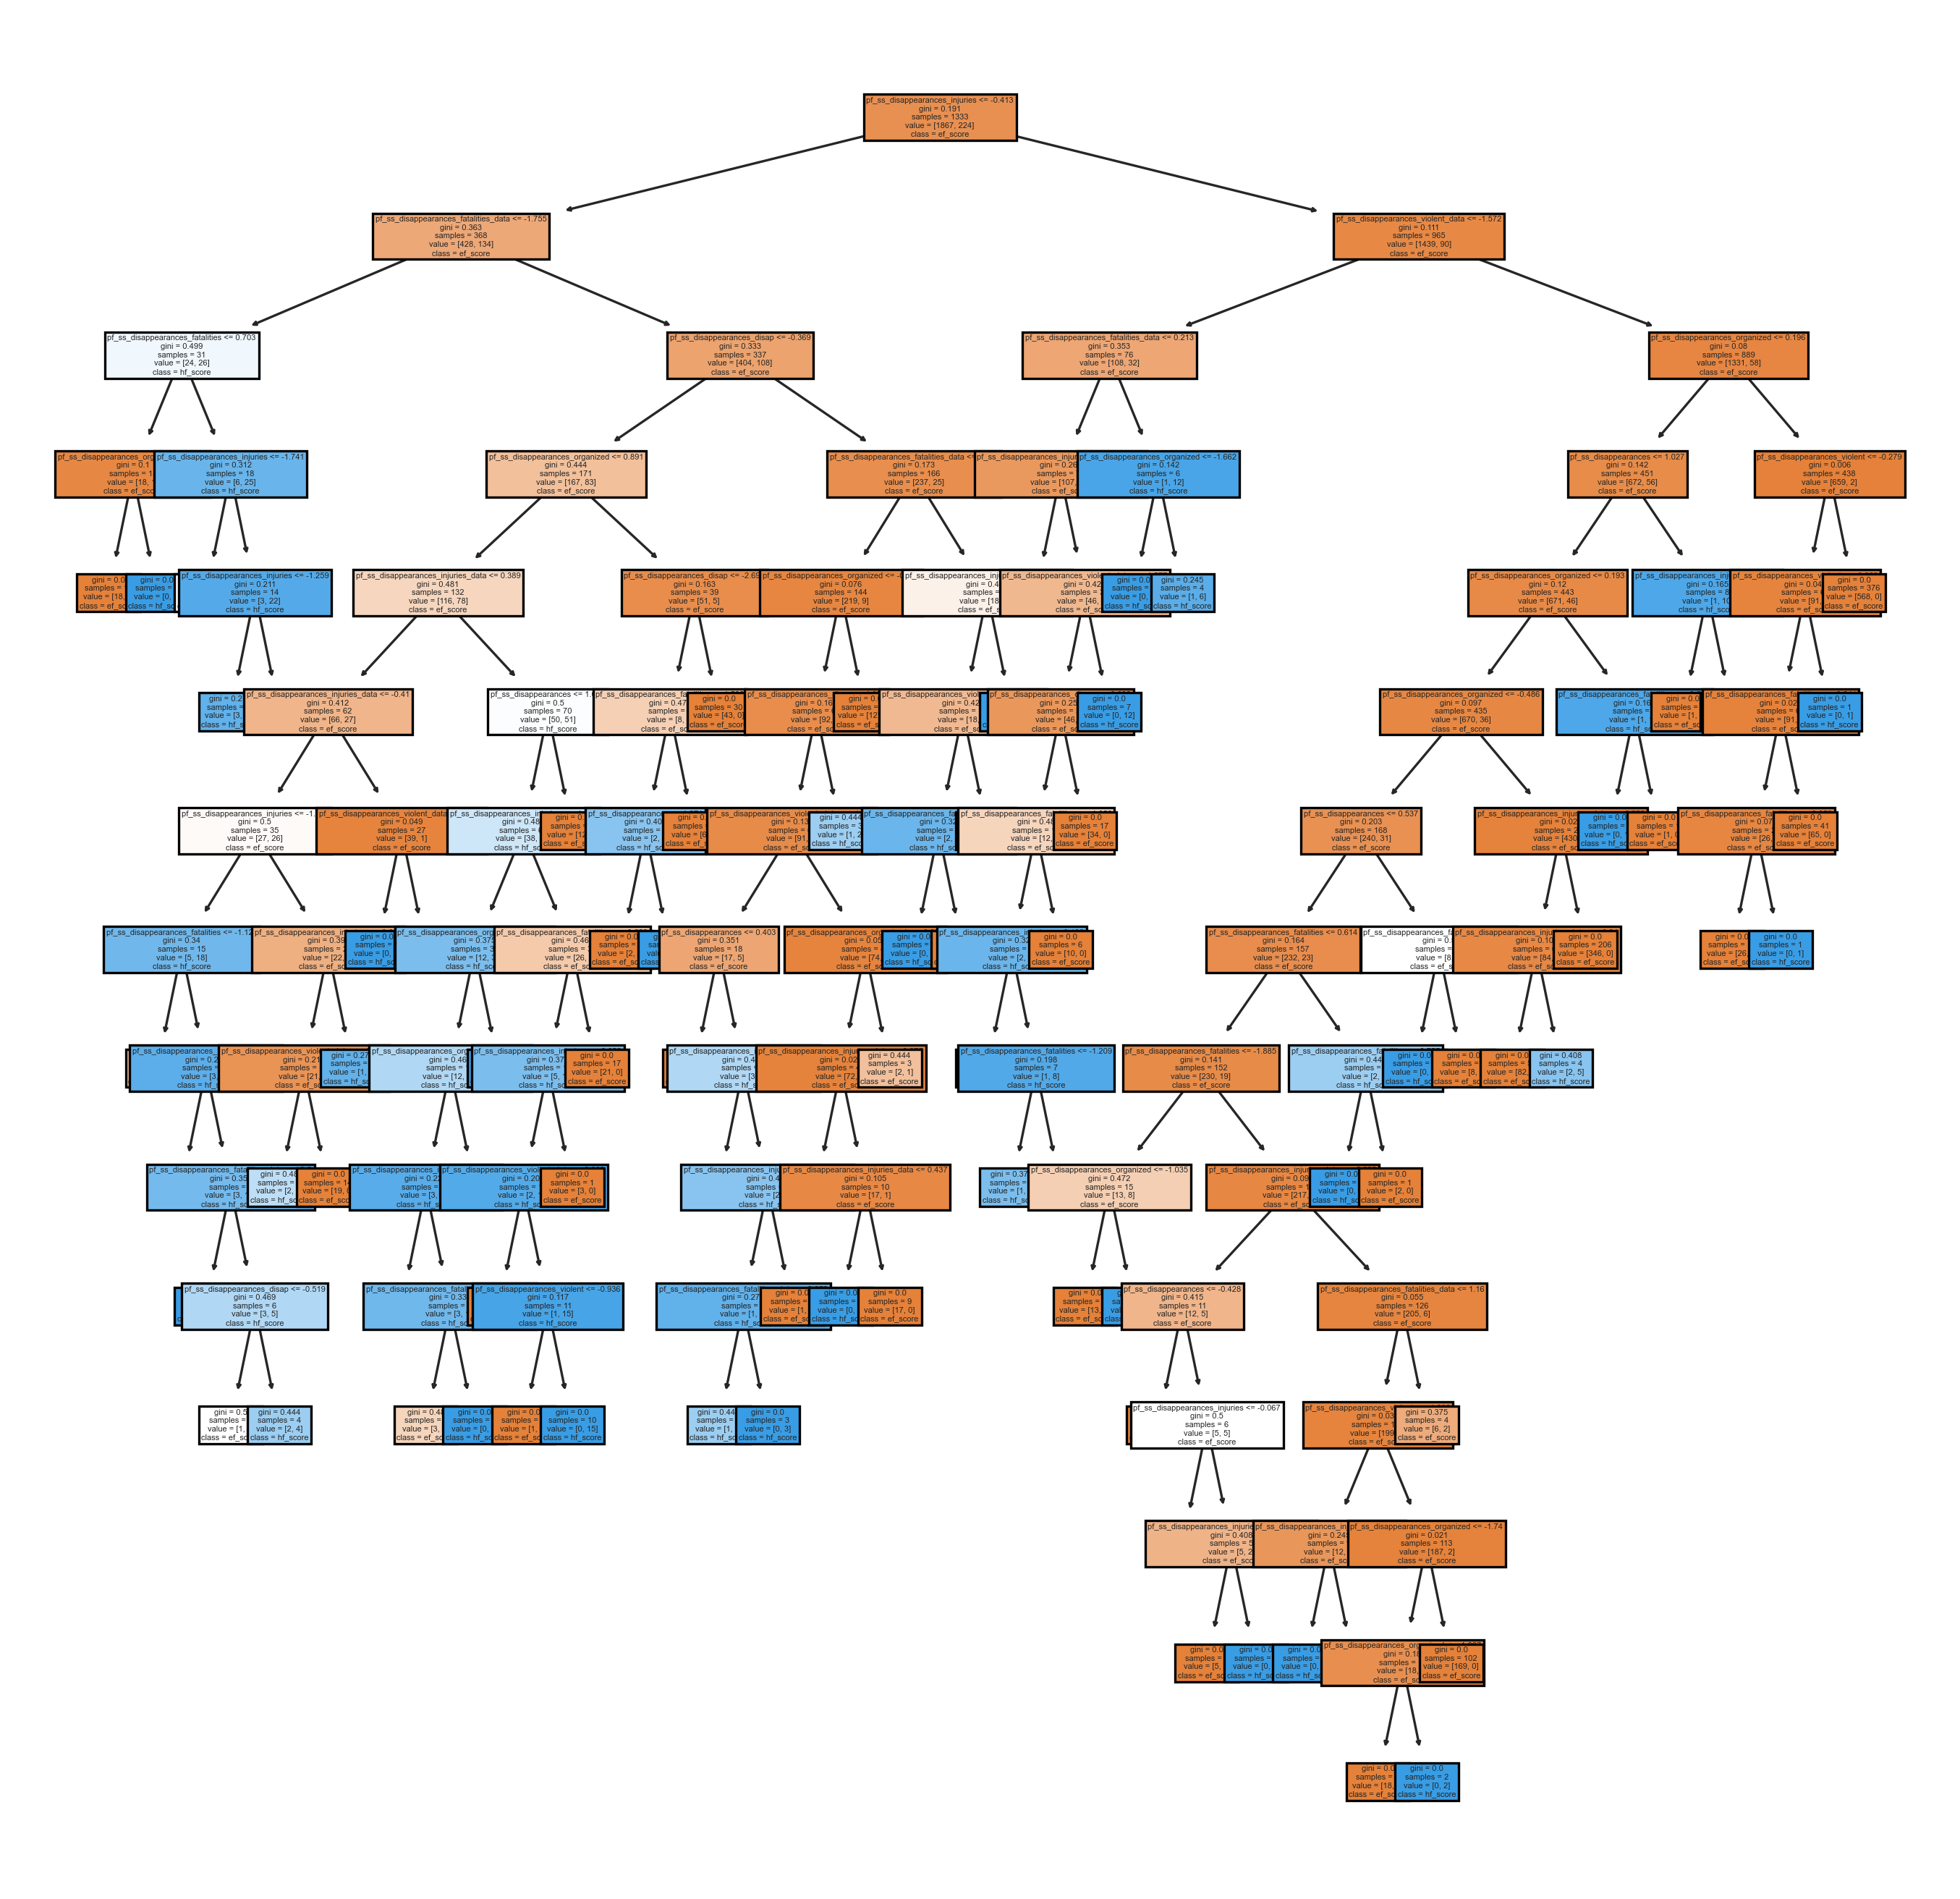

In [227]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Choose a tree from the random forest model
# Here we're choosing the first tree, but you can choose any tree
model = best_models_rf_temporal["ef_score"].estimators_[0]

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
plot_tree(model,
          feature_names = X_temp_train.columns, 
          class_names=y_temp_train.columns,
          filled = True)


In [228]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Create a time series split object
tscv = TimeSeriesSplit(n_splits=5)

# Define the grids of hyperparameters to search over
ada_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1]
}

# Initialize dictionary to store the best models and their scores
best_models_ada = {}
best_scores_ada = {}

for target in selected_features_dict.keys():
    print(f"\nPerforming grid search for models for {target}")
    best_features = list(selected_features_dict[target].keys())

    X_train_best = X_train[best_features]
    X_test_best = X_test[best_features]

    # Lists to store metrics for each outer fold
    accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

    for train_index, test_index in tscv.split(X_train_best):
        # Splitting the dataset into the Training set and Test set
        X_train_cv, X_val_cv = X_train_best.iloc[train_index], X_train_best.iloc[test_index]
        y_train_cv, y_val_cv = y_train[target].iloc[train_index], y_train[target].iloc[test_index]

        ada_grid = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=0), ada_params, cv=tscv)
        ada_grid.fit(X_train_cv, y_train_cv)

        best_models_ada[target] = ada_grid.best_estimator_
        best_scores_ada[target] = ada_grid.best_score_

        # Evaluate the model on the validation set
        y_pred_val = ada_grid.predict(X_val_cv)

        # Calculate evaluation metrics for this fold and append to respective lists
        accuracy_scores.append(accuracy_score(y_val_cv, y_pred_val))
        precision_scores.append(precision_score(y_val_cv, y_pred_val))
        recall_scores.append(recall_score(y_val_cv, y_pred_val))
        f1_scores.append(f1_score(y_val_cv, y_pred_val))

    # Print the best parameters and scores
    print(f"Best parameters for {target}: {ada_grid.best_params_}")
    print(f"Best cross-validation score for {target}: {best_scores_ada[target]:.4f}")

    # Print the averaged metrics
    print(f"Average validation accuracy: {np.mean(accuracy_scores):.4f}")
    print(f"Average validation precision: {np.mean(precision_scores):.4f}")
    print(f"Average validation recall: {np.mean(recall_scores):.4f}")
    print(f"Average validation F1-score: {np.mean(f1_scores):.4f}")

# Now you can evaluate your model on the test set
for target in selected_features_dict.keys():
    best_model = best_models_ada[target]
    best_features = list(selected_features_dict[target].keys())

    X_test_best = X_test[best_features]
    y_test_target = y_test[target]

    y_pred_test = best_model.predict(X_test_best)

    # Calculate and print the test metrics
    print(f"\nTest metrics for {target}:")
    print(f"Test accuracy: {accuracy_score(y_test_target, y_pred_test):.4f}")
    print(f"Test precision: {precision_score(y_test_target, y_pred_test):.4f}")
    print(f"Test recall: {recall_score(y_test_target, y_pred_test):.4f}")
    print(f"Test F1-score: {f1_score(y_test_target, y_pred_test):.4f}")


Performing grid search for models for ef_score
Best parameters for ef_score: {'learning_rate': 0.1, 'n_estimators': 150}
Best cross-validation score for ef_score: 1.0000
Average validation accuracy: 0.9971
Average validation precision: 0.9957
Average validation recall: 0.9704
Average validation F1-score: 0.9818

Performing grid search for models for hf_score
Best parameters for hf_score: {'learning_rate': 0.1, 'n_estimators': 150}
Best cross-validation score for hf_score: 1.0000
Average validation accuracy: 0.9971
Average validation precision: 0.9957
Average validation recall: 0.9704
Average validation F1-score: 0.9818

Performing grid search for models for pf_expression_bti
Best parameters for pf_expression_bti: {'learning_rate': 1, 'n_estimators': 100}
Best cross-validation score for pf_expression_bti: 0.9503
Average validation accuracy: 0.9391
Average validation precision: 0.9035
Average validation recall: 0.8949
Average validation F1-score: 0.8979

Performing grid search for model

In [229]:
from yellowbrick.classifier import ClassificationReport

for target in selected_features_dict.keys():
    best_features = list(selected_features_dict[target].keys())
    X_train_best = X_train[best_features]
    X_test_best = X_test[best_features]

    # Random Forest
    visualizer_rf = ClassificationReport(best_models_rf[target], classes=np.unique(y_train[target]), support=True)
    visualizer_rf.fit(X_train_best, y_train[target])  
    visualizer_rf.score(X_test_best, y_test[target])  
    visualizer_rf.show()       

    # XGBoost
    visualizer_xgb = ClassificationReport(best_models_xgb[target], classes=np.unique(y_train[target]), support=True)
    visualizer_xgb.fit(X_train_best, y_train[target])  
    visualizer_xgb.score(X_test_best, y_test[target])  
    visualizer_xgb.show()       

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- ef_legal_regulatory
- ef_money_currency
- ef_regulation_business_impartial
- ef_regulation_credit_interest
- ef_regulation_credit_private
- ...
Feature names seen at fit time, yet now missing:
- ef_government_tax_payroll_data
- ef_money
- ef_regulation
- ef_regulation_business
- ef_regulation_business_compliance
- ...


### Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

# Define the grids of hyperparameters to search over
nn_params = {
    'hidden_layer_sizes': [(50, 50), (100, 100), (150, 150), (100, 50), (150, 100)],
    'learning_rate_init': [0.01, 0.001, 0.0001],
    'max_iter': [200, 300, 400],
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # L2 penalty (regularization term) parameter
}

# Initialize dictionary to store the best models
best_models_nn = {}

for target in selected_features_dict.keys():
    print(f"Performing grid search for models for {target}")

    # Get the best features for the target
    best_features = list(selected_features_dict[target].keys())

    # Subset X_train and X_test to only include the best features
    X_train_best = X_train[best_features]
    X_test_best = X_test[best_features]

    # Perform grid search for the Neural Network model
    print("Performing grid search for Neural Network Model")
    nn_grid = GridSearchCV(MLPClassifier(random_state=0), nn_params, cv=5)
    nn_grid.fit(X_train_best, y_train[target])

    # Store the best model
    best_models_nn[target] = nn_grid.best_estimator_

    # Neural Network model
    print(f"Classification report for Neural Network model, {target}")
    y_pred_nn = best_models_nn[target].predict(X_test_best)
    print(classification_report(y_test[target], y_pred_nn))

Performing grid search for models for ef_score
Performing grid search for Neural Network Model


In this version of the code, I've added more hidden layers and neurons per layer to the hidden_layer_sizes parameter. The tuples in the hidden_layer_sizes list now represent the number of neurons in each layer of the network. For example, (50, 50) represents a network with two hidden layers, each containing 50 neurons. (100, 50) represents a network with two hidden layers, the first containing 100 neurons and the second containing 50.

I've also added the alpha parameter to the hyperparameter grid. This parameter controls the amount of L2 regularization applied to the network, which can help to prevent overfitting by penalizing large weights in the network. Adding this parameter to the grid search can help to find the optimal balance between model complexity and overfitting.

## Modelling: Spatial

### Bayesian Spatio-Temporal Interaction (BSTI) and  MGWR / GWR

In [ ]:
import scipy
print(scipy.__version__)

1.7.3


In [ ]:
%pip install geopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 5.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pymc3 as pm
import theano.tensor as tt
from scipy.spatial.distance import cdist
import geopy.distance
from theano import shared

In [ ]:
def haversine(coord1, coord2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

def get_distance_matrix(coords):
    dist_matrix = cdist(coords, coords, metric=haversine)
    return dist_matrix

In [ ]:
# Extract x and y from the geometry as separate features
gdf['lon'] = gdf['geometry'].centroid.x
gdf['lat'] = gdf['geometry'].centroid.y

# Store coordinates as list of tuples
coords = list(zip(gdf['lat'], gdf['lon']))

# spatial distance matrix
spatial_dist = get_distance_matrix(coords)

In [ ]:
# temporal distance matrix 
temporal_dist = np.abs(gdf['year'].values[:, None] - gdf['year'].values[None, :])

# spatio-temporal distance matrix
spatio_temporal_dist = spatial_dist + temporal_dist

In [ ]:
with pm.Model() as model:
    # Define the length scale parameter for the covariance function
    ls = pm.Gamma("ls", alpha=2, beta=1)
    
    # Define the covariance function
    cov_func = pm.gp.cov.ExpQuad(1, ls=ls)
    
    # Specify the mean function (this can be adjusted according to your needs)
    mean_func = pm.gp.mean.Zero()

    # The scale of the white noise term can be provided,
    noise = pm.HalfCauchy('noise', beta=3)

    # Define the GP
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
    
    # Define the observed data for the GP
    y = gdf['ef_score']
    X = gdf[selected_features_dict['ef_score']].values
    
    # Marginal likelihood
    y_ = gp.marginal_likelihood('y_', X=X, y=y, noise=noise)

    # Use a Maximum a Posteriori (MAP) estimation to find the best model parameters
    map_estimate = pm.find_MAP()

In [ ]:
# Define the observed data for the GP
outcomes_train = gdf['ef_score']

# Covariates (predictor features)
X = gdf[selected_features_dict['ef_score']].values

# Scale covariates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up shared variables
covariates_shared = shared(X_scaled)

# Spatio-temporal distance matrix
D_spatiotemporal = spatio_temporal_dist

In [ ]:
# Set up the model
with pm.Model() as model:
    # Priors
    l = pm.Gamma("l", alpha=2, beta=1)
    tau = pm.HalfCauchy("tau", beta=5)

    # Matern covariance function
    cov_func = tau**2 * pm.gp.cov.Matern32(1, ls=l)

    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X=D_spatiotemporal)

    # Expected value of outcome
    p = pm.Deterministic('p', pm.math.sigmoid(f))

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Bernoulli('y_obs', p=p, observed=outcomes_train)

# Get the MAP estimate
with model:
    print("Finding the MAP estimate...")
    map_estimate = pm.find_MAP()
    print("MAP estimate found.")

# Fit the model with fewer iterations
with model:
    print("Starting MCMC sampling...")
    trace = pm.sample(500, tune=500, target_accept=0.95)
    print("MCMC sampling completed.")

Finding the MAP estimate...



MAP estimate found.
Starting MCMC sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, tau, l]


In [ ]:
# Set up the model
with pm.Model() as model:
    # Priors
    l = pm.Gamma("l", alpha=2, beta=1)
    tau = pm.HalfCauchy("tau", beta=5)
    cov_func = tau**2 * pm.gp.cov.ExpQuad(1, ls=l)

    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X=D_spatiotemporal)

    # Expected value of outcome
    p = pm.Deterministic('p', pm.math.sigmoid(f))

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Bernoulli('y_obs', p=p, observed=outcomes_train)

# Fit the model
with model:
    print("Starting model fitting...")
    trace = pm.sample(100, tune=100, target_accept=0.95)

    # Print progress during model fitting
    for i in range(1, 101):
        if i % 100 == 0:
            print(f"Progress: {i}/100 iterations")

print("Model fitting completed.")

## Modelling: Genetic

In [ ]:
from tpot import TPOTClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Initialize dictionaries to store models and their feature importances
models = {}
feature_importances = {}

# Create a time series split object
tscv = TimeSeriesSplit(n_splits=5)

# Define the search space for models and hyperparameters with expanded ranges
tpot_config = {
    'sklearn.ensemble.AdaBoostClassifier': {
        'n_estimators': range(50, 251, 50),
        'learning_rate': [0.01, 0.1, 1],
        'base_estimator': [
            DecisionTreeClassifier(max_depth=1),
            DecisionTreeClassifier(max_depth=2),
            DecisionTreeClassifier(max_depth=3)
        ]
    },
    'sklearn.ensemble.RandomForestClassifier': {
        'n_estimators': range(100, 401, 100),
        'max_depth': [3, 5, 7, None],
        'min_samples_split': range(2, 11, 2)
    },
    'sklearn.svm.SVC': {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['linear', 'rbf']
    },
    'sklearn.ensemble.GradientBoostingClassifier': {
        'n_estimators': range(50, 251, 50),
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 5, 7]
    },
    'xgboost.XGBClassifier': {
        'n_estimators': range(50, 251, 50),
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 5, 7]
    },
    'lightgbm.LGBMClassifier': {
        'n_estimators': range(50, 251, 50),
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 5, 7]
    },
    'sklearn.naive_bayes.GaussianNB': {
    },
    'sklearn.ensemble.ExtraTreesClassifier': {
        'n_estimators': range(100, 401, 100),
        'max_depth': [3, 5, 7, None],
        'min_samples_split': range(2, 11, 2)
    },
    'sklearn.ensemble.BaggingClassifier': {
        'n_estimators': range(10, 101, 20),
        'base_estimator': [None, DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=5)]
    }
}

for target, best_features in selected_features_dict.items():
    print(f"Training model for {target}")

    # Subset X_train and X_test to only include the best features
    X_train_best = X_train[best_features]
    X_test_best = X_test[best_features]

    # Initialize TPOT with the desired configuration
    tpot = TPOTClassifier(generations=20, population_size=100, cv=tscv, config_dict=tpot_config, random_state=0, verbosity=2)

    # Fit TPOT to the training data with the best features
    tpot.fit(X_train_best, y_train[target])

    # Store the best pipeline found by TPOT for the target
    best_pipeline = tpot.fitted_pipeline_
    models[target] = best_pipeline

    # Check if the model has feature_importances_ attribute
    if hasattr(best_pipeline.steps[-1][1], "feature_importances_"):
        # Get feature importances
        importances = best_pipeline.steps[-1][1].feature_importances_
        # Match importances with feature names
        feature_importance_dict = dict(zip(best_features, importances))
        feature_importances[target] = feature_importance_dict
    else:
        print(f"The best model for target {target} does not support feature importances")

    # Make predictions on the test set with the best features
    y_pred = tpot.predict(X_test_best)

    # Generate classification report
    report = classification_report(y_test[target], y_pred)
    
        # Print classification report
    print(f"Classification Report for {target}:")
    print(report)

# After the loop, you can print out the feature importances
for target, importance_dict in feature_importances.items():
    print(f"\nFeature importances for target {target}:")
    for feature, importance in sorted(importance_dict.items(), key=lambda item: item[1], reverse=True):
        print(f"Feature: {feature}, Importance: {importance}")

Training model for ef_score
                                                                              
Generation 1 - Current best internal CV score: 0.9945812807881774
                                                                              
Generation 2 - Current best internal CV score: 0.9950738916256159
                                                                              
Generation 3 - Current best internal CV score: 0.9955665024630541
                                                                              
Generation 4 - Current best internal CV score: 0.9955665024630541
                                                                              
Generation 5 - Current best internal CV score: 0.9955665024630541
                                                                                
Generation 6 - Current best internal CV score: 0.9955665024630541
                                                                                  
Generation 7 - Cu

In [ ]:
from tpot import TPOTClassifier
from sklearn.model_selection import TimeSeriesSplit

# Define the cross-validation procedure
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the TPOT classifier
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2,
                      scoring='accuracy', cv=tscv, random_state=42,
                      config_dict='TPOT light')

# Perform optimization and feature selection for each target
for target in y_train.columns:
    tpot.fit(X_train_numeric, y_train[target])
    print(f"Best pipeline for target {target} is: \n{tpot.fitted_pipeline_}")

# Export the pipeline for each target as a Python script file
tpot.export('optimized_pipeline.py')